In [33]:
%run ../talktools.py

<Figure size 432x288 with 0 Axes>

# Neural Networks and Deep Learning 

If you're not using `datahub`, but instead using your laptop, it's a good idea to make sure you've got the most recent ML frameworks. These commands can take awhile so don't do them during lecture time.

<pre>
pip install -U pydot-ng scikit-learn

# TensorFlow & Keras
conda update -f -c conda-forge keras tensorflow protobuf
</pre>

### What are artificial neural networks (ANN)?

   - A set of methodologies for doing machine learning
   - Collection/composition of simple mathematical functions whose parameterization is *learned* by passing over the data
   - Deep Learning is a kind of ANN that has a certain architecture (more later).
   
### Why do people like it?
   - It's "inspired" by how the brain is thought to work, so it *feels* like a natural approach. 
   - It works. Amazingly well. In a growing number of use cases.
   - It's composable, so it's "easy" to understand each piece.
   - Featurizes + learns on "raw" data.
   - Timely: It's tractable with the data/problems we have and the compute power we have access to.
   - New shiny object with codebases getting commoditized (read: easier and easier to use...and free).

### Why do people dislike it?
   - Decades of hype
   - It's considered a black box in a lot of ways
   - It can take a ninja to get it right
   - It's expensive to run/learn a model
   - Not natively adapted to heterogeneous data and certain types of learning
   - Not the approach of choice for small/medium data
   - Common criticism: results can be challenging to interpret


<img src="http://fastml.com/images/ai/new_navy_device_learns_by_doing.jpg" width="80%">

## The "Neuron" ("Perceptron")
<img src="https://www.evernote.com/l/AUVUbm0I38pMWbUhfC0VUZv7qxxguDOy64QB/image.png">
Source: http://www.wsdm-conference.org/2016/slides/WSDM2016-Jeff-Dean.pdf

<img width="50%" src="http://www.webpages.ttu.edu/dleverin/neural_network/fig_3p6_neurons_NEURON4.jpg">
Source: http://www.webpages.ttu.edu/dleverin/neural_network/neural_networks.html

The key is to *learn* the weights $w_i$ given the data. This is done as such:

  1. Initialization:
      - Set the transfer (e.g. sum) & activation (sigmoid) functions you want to use.
      - randomly assign the weights (with some probability distribution)
  2. For each instance $i$, run your input $\vec x_i$ through the network with current weights to get the current output.
  3. Determine $\Delta$ how far off the current output is from the true output/labels.
  4. Update the weights by taking the gradient of the activation at $\vec x_i$ and multiplying by $\Delta$.
  5. Repeat steps 2--5 until you hit a stopping criteria.
  
This process is an optimization and is called **"Back Propogation"** and, if your activation function is differentiable, it's basically a form of gradient descent and reduces to doing simple linear algebra to find the optimimal weights given the data.  It was first presented by Rumelhart, Hinton, Williams ([Nature, 1986](http://www.iro.umontreal.ca/~pift6266/A06/refs/backprop_old.pdf))

## Single Layer Network Example

In [2]:
import numpy as np
# input dataset
X = np.array([  [0,0,1],
                         [0,1,1],
                         [1,0,1],
                         [1,1,1] ])

# output label
Y = np.array([[0,0,1,1]]).T

In [3]:
Y

array([[0],
       [0],
       [1],
       [1]])

<img src="https://imiloainf.files.wordpress.com/2013/11/activation_funcs1.png" width="50%">

See: https://en.wikipedia.org/wiki/Activation_function

In [4]:
def transfer(wx):
    " how to aggregate the weighted inputs "
    return np.sum(wx,axis=1)

def activation(twx,func="ReLU",derivative=False):
    " how to treat the sum of the weighted input "
    if func == "ReLU":
        if derivative:
            return np.array([0 if x <= 0 else 1 for x in twx])
        return np.array([max(0,x) for x in twx])
    
    if func == "sigmoid":
        if derivative:
            return np.array([x*(1-x) for x in twx])
        return np.array([1/(1+np.exp(-x)) for x in twx])
    
    if func == "tanh":
        if derivative:
            return np.array([1 - (np.tanh(x))**2 for x in twx])
        return np.array([np.tanh(x) for x in twx])
    
    raise

In [5]:
np.random.seed(42)
weights_initial = 2*np.random.random((3,1)) - 1
weights_initial

array([[-0.25091976],
       [ 0.90142861],
       [ 0.46398788]])

In [6]:
rms_error = {"tanh": [], "sigmoid": []}

for func in ["tanh", "sigmoid"]:

    weights = weights_initial.copy()

    for _ in range(10000):
        # forward propagation
        layer0 = X
        sum_of_weighted_X = transfer(layer0*weights.T)
        layer1 = activation(sum_of_weighted_X, func=func)

        # how much did we miss?
        layer1_error = Y.T - layer1

        rms_error[func].append(np.sqrt((layer1_error**2).sum()))
        # multiply how much we missed by the
        # slope of the activation at the values in layer1
        layer1_delta = layer1_error * activation(layer1,derivative=True)

        weights += np.dot(layer1_delta, layer0).T

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

Text(0.5, 1.0, 'Single Layer NN')

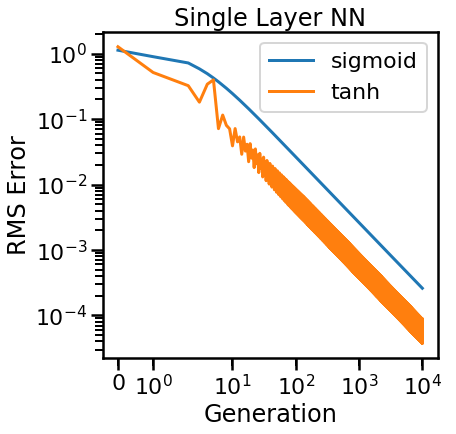

In [8]:
plt.figure(figsize=(6,6))

plt.plot(rms_error["sigmoid"],label="sigmoid")
plt.plot(rms_error["tanh"],label="tanh")

plt.xscale("symlog")
plt.yscale("log")
plt.ylabel("RMS Error")
plt.xlabel("Generation")
plt.legend()
plt.title("Single Layer NN")

Note we updated the weights at each pass by using all the instances (this is called "batch learning"). There are speed ups (but generally noisier learning) by randomly choosing a subset of the data at each iteration ("stochastic learning").

See [LeCun, Bottou, Orr, & Muller 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) for more info.

## Multi-Layer Networks

Multilayer networks are not really any different. They have more weights to learn but they may also represent more complex models. Backpropogation optimization still works, this time by using the chain rule. That is, optimization is multi-step but it's  local to individual layers (this makes the problem tractable).

<img src="http://scikit-learn.org/stable/_images/multilayerperceptron_network.png" width="50%">

The above network is said to have a hidden layer, which is neither an input nor an output layer.

In sklearn there are a few solver for backpropogation optimization:
  - ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
  - ‘sgd’ refers to stochastic gradient descent.
  - ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

In [9]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs',activation="tanh",
                    hidden_layer_sizes=(5,2), random_state=42)

In [10]:
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])

# output label
Y = np.array([0,0,1,1])

In [11]:
clf.fit(X, Y)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [12]:
%run draw_nn.py

<Figure size 432x288 with 0 Axes>

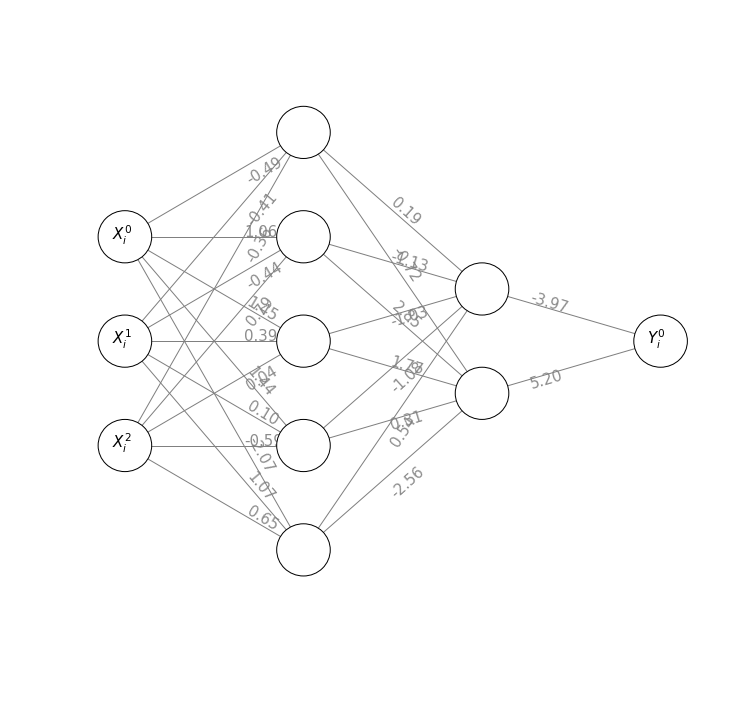

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_MLP_model(fig.gca(),clf)

In [14]:
print("Iterations:", clf.n_iter_)

Iterations: 23


In [15]:
clf.predict(np.array([0,0,0]).reshape(1, -1))

array([0])

In [16]:
clf.predict_proba(np.array([1,1,1]).reshape(1, -1))

array([[1.46663997e-04, 9.99853336e-01]])

In [17]:
clf.classes_

array([0, 1])

In [18]:
clf.predict(X)

array([0, 0, 1, 1])

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])

# output label
Y = [["sad","mouse"],["happy","dog"],["sad","mouse"],["happy","quasar"]]

mlb = MultiLabelBinarizer()
Y1 = mlb.fit_transform(Y)

In [20]:
Y1

array([[0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0]])

In [21]:
clf = MLPClassifier(solver='lbfgs', activation="tanh",
                    hidden_layer_sizes=(6,5,6), random_state=1)
clf.fit(X, Y1)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(6, 5, 6), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

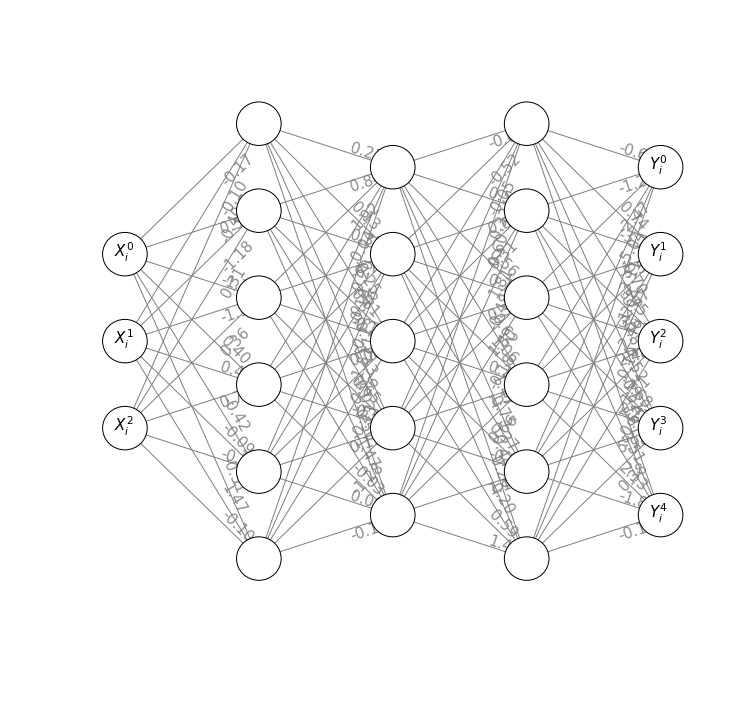

In [22]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_MLP_model(fig.gca(),clf)

In [23]:
newx = np.array([0,0,1]).reshape(1,3)
clf.predict(newx)

array([[0, 0, 1, 0, 1]])

In [24]:
from sklearn import datasets
cal_house = datasets.california_housing
cal_data = cal_house.fetch_california_housing()
X = cal_data['data']   # 8 features 
Y = cal_data['target'] # response (median house price)
half = math.floor(len(Y)/2)
train_X = X[:half]
train_Y = Y[:half]
test_X = X[half:]
test_Y = Y[half:]

In [25]:
train_X[0,:]

array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])

In [26]:
train_Y[0]

4.526

In [27]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Don't cheat - fit only on training data
scaler.fit(train_X)  
train_X = scaler.transform(train_X)  

# apply same transformation to test data
test_X = scaler.transform(test_X)

In [28]:
train_X[0,:]

array([ 2.38855924,  0.79291788,  0.62690224, -0.12508017, -0.97853477,
       -0.08340845,  1.21206764, -1.54460746])

In [29]:
train_Y[0]

4.526

In [30]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(activation="tanh",alpha=0.1,solver='sgd',
                   nesterovs_momentum=False, learning_rate_init=0.2,
                   hidden_layer_sizes=(20,20,20,5), random_state=1, max_iter = 400)
clf.fit(train_X, train_Y)

MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20, 5), learning_rate='constant',
       learning_rate_init=0.2, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=False, power_t=0.5,
       random_state=1, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Text(0, 0.5, 'Predicted Y')

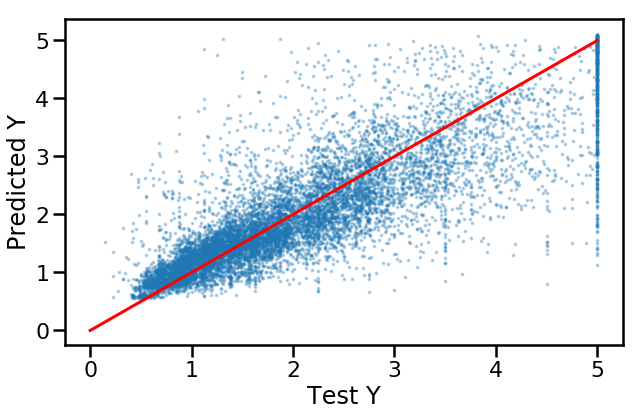

In [31]:
plt.figure(figsize=(10,6))
plt.scatter(test_Y,clf.predict(test_X),alpha=0.3,s=3)
plt.plot([0, 5], [0, 5], c="r", ls="-")
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")

In [32]:
clf.score(test_X,test_Y)

0.6697625249262775

[multi-layer neural nets in the Browser]( http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.65948&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)